In [1]:
import os
from dotenv import load_dotenv
import praw
import pandas as pd



In [2]:

load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_SECRET"),
    username=os.getenv("REDDIT_USERNAME"),
    password=os.getenv("REDDIT_PASSWORD"),
    user_agent=os.getenv("REDDIT_USER_AGENT")
)

print("Logged in as:", reddit.user.me())


Logged in as: Sad-State-7591


In [3]:
import re

# Define aliases
am_aliases = [
    "aston martin", "amf1", "alonso", "stroll", 
    "green car", "fernando", "lance", "aston"
]

def contains_alias(text):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    return any(alias in text for alias in am_aliases)

# Step 1: Scrape posts from r/formula1
subreddit = reddit.subreddit("formula1")
posts = []

for post in subreddit.new(limit=1000):
    combined_text = (post.title + " " + post.selftext)
    if contains_alias(combined_text):
        post_data = {
            "type": "post",
            "post_id": post.id,
            "title": post.title,
            "text": post.selftext,
            "upvotes": post.score,
            "created_utc": post.created_utc,
            "url": post.url
        }
        posts.append(post_data)

        # Step 2: Scrape top-level comments from that post
        post.comments.replace_more(limit=0)  # Flatten comment tree
        for comment in post.comments.list():
            if contains_alias(comment.body):
                comment_data = {
                    "type": "comment",
                    "post_id": post.id,
                    "title": "",  # No title for comment
                    "text": comment.body,
                    "upvotes": comment.score,
                    "created_utc": comment.created_utc,
                    "url": f"https://reddit.com{comment.permalink}"
                }
                posts.append(comment_data)

# Create DataFrame
df = pd.DataFrame(posts)
print(f"Total items collected (posts + comments): {len(df)}")

Total items collected (posts + comments): 2042


# BASIC TEXT EXPLORATION

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

# For co-occurrence and lift
from itertools import combinations
from collections import defaultdict

In [5]:
#Create a data frame with the posts info
df = pd.DataFrame(posts)

#Combine title and text
df['content'] = df['title'] + " " + df['text']

stop_words =  set(stopwords.words('english'))

def basic_preprocessing(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

df['cleaned'] = df['content'].apply(basic_preprocessing)

Top 20 most frequent words:
alonso: 1201
stroll: 666
car: 422
aston: 353
would: 311
like: 310
team: 290
lance: 281
hes: 257
lawson: 252
driver: 247
points: 230
think: 216
even: 214
max: 199
time: 198
race: 198
one: 198
fernando: 193
season: 192


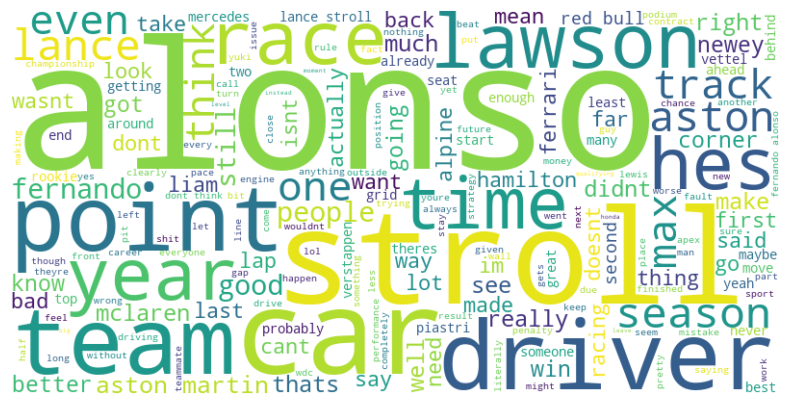

In [6]:
#Word frequency
# Flatten all tokens into a single list
all_tokens = [token for sublist in df['cleaned'] for token in sublist]

# Count word frequencies
word_freq = Counter(all_tokens)

# Display top 20 words
print("Top 20 most frequent words:")
for word, freq in word_freq.most_common(20):
    print(f"{word}: {freq}")

# Optional: Word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
#I want to check how associated is aston martin with other teams. But for this I have to change the scrapping code to get all the posts and comments, not just the ones with aston martin.
# Step 1: Scrape all recent posts from r/formula1
subreddit = reddit.subreddit("formula1")
items = []

for post in subreddit.new(limit=1000):
    # Append the post (no filtering!)
    items.append({
        "type": "post",
        "post_id": post.id,
        "title": post.title,
        "text": post.selftext,
        "upvotes": post.score,
        "created_utc": post.created_utc,
        "url": post.url
    })

    # Step 2: Scrape all comments from that post
    try:
        post.comments.replace_more(limit=0)  # Load all comments
        for comment in post.comments.list():
            items.append({
                "type": "comment",
                "post_id": post.id,
                "title": "",  # Comments don't have titles
                "text": comment.body,
                "upvotes": comment.score,
                "created_utc": comment.created_utc,
                "url": f"https://reddit.com{comment.permalink}"
            })
    except Exception as e:
        print(f"Error loading comments for post {post.id}: {e}")

# Create DataFrame
df = pd.DataFrame(items)
print(f"Total items collected (posts + comments): {len(df)}")

Total items collected (posts + comments): 112714


In [8]:
#Export the comments to a csv file
df.to_csv("posts_comments.csv", index=False)
#Read the csv file
# df = pd.read_csv("posts_comments.csv")

In [9]:
#Based on those comments + posts associated with AM, I want to know the relationship with other teams
# Create a list of all teams
team_aliases = {
    "aston martin": ["aston martin", "aston", "amf1", "green car", "stroll", "alonso", "fernando", "lance"],
    "red bull": ["red bull", "rb", "rbr", "verstappen", "max", "checo", "perez", "newey", "horner"],
    "mercedes": ["mercedes", "merc", "hamilton", "lewis", "russell", "george", "toto"],
    "ferrari": ["ferrari", "charles", "leclerc", "carlos", "sainz", "fred", "vasseur"],
    "mclaren": ["mclaren", "lando", "norris", "piastri", "oscar", "zak"],
    "alpine": ["alpine", "ocon", "gasly", "renault", "pink car"],
    "williams": ["williams", "albon", "logan", "sargeant"],
    "stake": ["stake", "zhou", "bottas", "sauber"],  # Formerly Alfa Romeo
    "alphatauri": ["alphatauri", "ricciardo", "tsunoda", "rb junior", "rbj", "yuki"],
    "haas": ["haas", "magnussen", "hulkenberg", "nico", "kmag"]
}

alias_to_team = {}
for team, aliases in team_aliases.items():
    for alias in aliases:
        alias_to_team[alias] = team

import re

def extract_teams_from_text(text, alias_lookup):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    mentioned_teams = set()
    for word in words:
        if word in alias_lookup:
            mentioned_teams.add(alias_lookup[word])
    return list(mentioned_teams)

df["teams_mentioned"] = df["text"].apply(lambda x: extract_teams_from_text(x, alias_to_team))



In [10]:
#I want to calculate the co-occurence of each team with AM using Lift
from collections import defaultdict
import pandas as pd

# Total number of comments/posts
N = len(df)

# Step 1: Count total mentions of each team
team_totals = defaultdict(int)
for teams in df["teams_mentioned"]:
    for team in teams:
        team_totals[team] += 1

# Step 2: Count co-mentions with Aston Martin
co_occurrence_counts = defaultdict(int)
for teams in df["teams_mentioned"]:
    if "aston martin" in teams:
        for team in teams:
            if team != "aston martin":
                co_occurrence_counts[team] += 1

# Step 3: Calculate Lift
lift_data = []
count_am = team_totals["aston martin"]

for team, co_count in co_occurrence_counts.items():
    count_b = team_totals[team]
    prob_a = count_am / N
    prob_b = count_b / N
    prob_ab = co_count / N
    lift = prob_ab / (prob_a * prob_b) if prob_a * prob_b > 0 else 0
    lift_data.append((team, co_count, count_b, lift))

# Step 4: Create and sort DataFrame
lift_df = pd.DataFrame(lift_data, columns=["team", "co_mentions_with_aston", "total_mentions", "lift"])
lift_df = lift_df.sort_values(by="lift", ascending=False)

# Show results
print(lift_df)


         team  co_mentions_with_aston  total_mentions      lift
5        haas                     127             902  3.754420
0      alpine                     261            2217  3.139210
7       stake                     102             922  2.949951
6    williams                     158            2028  2.077470
2    mercedes                     698           10122  1.838801
3    red bull                     904           14474  1.665427
4  alphatauri                     137            2384  1.532357
1     ferrari                     444            8948  1.323130
8     mclaren                     446           11867  1.002166


In [29]:
#Now, I want to understand the types of merchandise that is being discussed in the posts and comments
merch_terms = [
    "merch", "gear", "apparel", "clothing", "cap", "hat", "shirt", "t-shirt", "jersey", 
    "hoodie", "jacket", "sweater", "sweatshirt", "scarf", "gloves", "beanie",
    "backpack", "bag", "keychain", "pin", "poster", "sticker",
    "store", "shop", "collection", "limited", "edition", "release", 
    "sold out", "buy", "purchase", "quality", "price", "design", "style", "fit"
]

In [30]:
def mentions_merch_type(text):
    text = text.lower()
    return any(term in text for term in merch_terms)

df["mentions_merch"] = df["text"].apply(mentions_merch_type)
df_merch = df[df["mentions_merch"] == True]

In [13]:
#Extract and count merch items
from collections import Counter
import re

# Tokenize and count merch items
all_merch_words = []
for text in df_merch["text"]:
    tokens = re.findall(r'\b\w+\b', text.lower())
    for word in tokens:
        if word in merch_terms:
            all_merch_words.append(word)

merch_counts = Counter(all_merch_words)
print(merch_counts.most_common(20))


[('look', 2199), ('design', 495), ('style', 398), ('drop', 348), ('buy', 323), ('cap', 317), ('release', 308), ('quality', 292), ('merch', 224), ('limited', 222), ('fit', 217), ('shirt', 185), ('poster', 154), ('hat', 153), ('gear', 116), ('price', 113), ('bag', 91), ('edition', 88), ('jacket', 65), ('pin', 61)]


In [14]:
merch_categories = {
    "headwear": ["cap", "hat", "beanie"],
    "tops": ["shirt", "t-shirt", "hoodie", "jacket", "jersey", "sweater", "sweatshirt"],
    "accessories": ["keychain", "bag", "backpack", "pin", "scarf", "gloves", "poster", "sticker"],
    "shop terms": ["store", "drop", "release", "buy", "price", "sold out", "quality"]
}

# Category counts
category_counter = Counter()
for word in all_merch_words:
    for cat, items in merch_categories.items():
        if word in items:
            category_counter[cat] += 1

print(category_counter)


Counter({'shop terms': 1440, 'headwear': 470, 'accessories': 379, 'tops': 304})


In [15]:
#Text Pre-processing for sentiment analysis
import re

#Step 1: apply basic text cleaning
def clean_text_basic(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"\@[\w_]+", "", text)  # remove mentions
    text = re.sub(r"\#[\w_]+", "", text)  # remove hashtags
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation and emojis
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

#Step 2: Tokenize the text
def tokenize_text(text):
    return word_tokenize(text)

#Step 3: Remove stop words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

#Step 4: Lemmatize the tokens
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

#Step 5: Combine all steps
def preprocess_text(text):
    text = clean_text_basic(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)
# Apply preprocessing
df["cleaned_text"] = df["text"].apply(preprocess_text)

VADER Sentiment Counts:
vader_sentiment_class
positive    51088
neutral     35072
negative    26554
Name: count, dtype: int64


/var/folders/7z/47q7rxfx55x97dcz64l8v83m0000gn/T/ipykernel_30431/1296198263.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="vader_sentiment_class", data=df, palette="Set2")


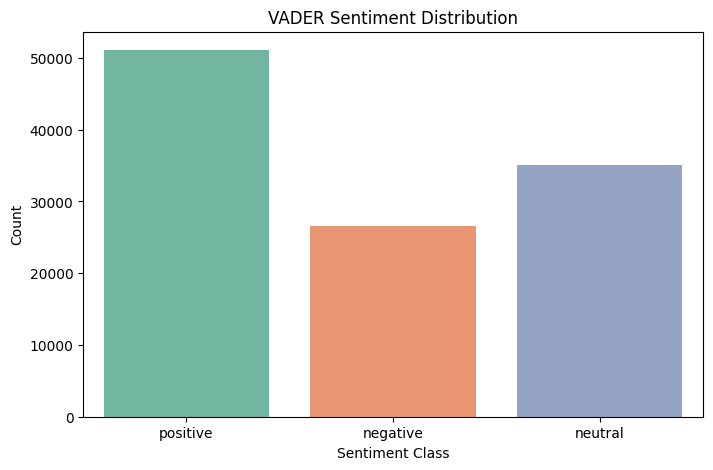

In [16]:
#Apply sentiment analysis
#Approach 1: Using VADER
analyzer = SentimentIntensityAnalyzer()
def analyze_sentiment_vader(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment["compound"]

# Apply VADER sentiment analysis
df["vader_sentiment"] = df["cleaned_text"].apply(analyze_sentiment_vader)
# Step 2: Classify sentiment
def classify_sentiment_vader(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"
df["vader_sentiment_class"] = df["vader_sentiment"].apply(classify_sentiment_vader)
# Step 3: Count sentiment classes
sentiment_counts = df["vader_sentiment_class"].value_counts()
print("VADER Sentiment Counts:")
print(sentiment_counts)
# Step 4: Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="vader_sentiment_class", data=df, palette="Set2")
plt.title("VADER Sentiment Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

In [19]:
#Apply Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert text to bag-of-words
vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_text'])  # list of preprocessed texts

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)
# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:
f1 question read news comment photo involved action mclaren rule
Topic 1:
team year engine new mercedes ferrari f1 car think driver
Topic 2:
max penalty corner red lap bull driver second yuki track
Topic 3:
post miami gp year statistic point yes monaco rule question
Topic 4:
car driver good season race best year time hamilton f1
Topic 5:
like look deleted love livery red ferrari thats oh fuck
Topic 6:
like im people dont know thing think f1 thats say
Topic 7:
race pit track stop na sprint tyre gon lap time
Topic 8:
car like track speed lewis straight make better air need
Topic 9:
lando year win max oscar mclaren norris think ferrari championship


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Positive
vectorizer_pos = TfidfVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm_positive = vectorizer_pos.fit_transform(df_positive['cleaned_text'])
lda_positive = LatentDirichletAllocation(n_components=5, random_state=42)
lda_positive.fit(dtm_positive)

# Negative
vectorizer_neg = TfidfVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm_negative = vectorizer_neg.fit_transform(df_negative['cleaned_text'])
lda_negative = LatentDirichletAllocation(n_components=5, random_state=42)
lda_negative.fit(dtm_negative)

# Display function
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display results
print("🔵 Positive Sentiment Topics:")
display_topics(lda_positive, vectorizer_pos.get_feature_names_out(), 5)

print("\n🔴 Negative Sentiment Topics:")
display_topics(lda_negative, vectorizer_neg.get_feature_names_out(), 5)


🔵 Positive Sentiment Topics:
Topic 0:
car yes like race track
Topic 1:
car max race driver point
Topic 2:
like year team driver max
Topic 3:
lmao love race like good
Topic 4:
lol post thanks news photo

🔴 Negative Sentiment Topics:
Topic 0:
penalty red bull team car
Topic 1:
stop race car pit miss
Topic 2:
max shit corner track hate
Topic 3:
fuck damn max penalty na
Topic 4:
car year race driver bad


In [39]:
#Re-filter the merch related posts and comments
merch_terms = [
    "merch", "gear", "apparel", "clothing", "cap", "hat", "shirt", "t-shirt", "jersey", 
    "hoodie", "jacket", "sweater", "sweatshirt", "scarf", "gloves", "beanie",
    "backpack", "bag", "keychain", "pin", "poster", "sticker",
    "store", "shop", "collection", "limited", "edition", 
    "sold out", "buy", "purchase", "quality", "price", "design", "style", "fit"
]

import re

def mentions_merch_type(text):
    text = text.lower()
    pattern = r'\b(?:' + '|'.join(re.escape(term) for term in merch_terms) + r')\b'
    return re.search(pattern, text) is not None

df["mentions_merch"] = df["cleaned_text"].apply(mentions_merch_type)

In [43]:
#I'll repeat the process for merch related posts
# Filter the DataFrame for posts and comments that mention merchandise
df_merch = df[df["mentions_merch"] == True]
# Convert text using tfidf
vectorizer_merch = TfidfVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm_merch = vectorizer_merch.fit_transform(df_merch['cleaned_text'])
lda_merch = LatentDirichletAllocation(n_components=5, random_state=42)
lda_merch.fit(dtm_merch)
# Display results
print("🛍️ Merchandise Topics:")
display_topics(lda_merch, vectorizer_merch.get_feature_names_out(), 5)

🛍️ Merchandise Topics:
Topic 0:
quality lol price jersey gear
Topic 1:
car cap design cost team
Topic 2:
shirt buy jacket merch look
Topic 3:
style car max driver driving
Topic 4:
hat edition merch design red


VADER Sentiment Counts for Merchandise:
vader_sentiment_class
positive    2044
negative     809
neutral      591
Name: count, dtype: int64


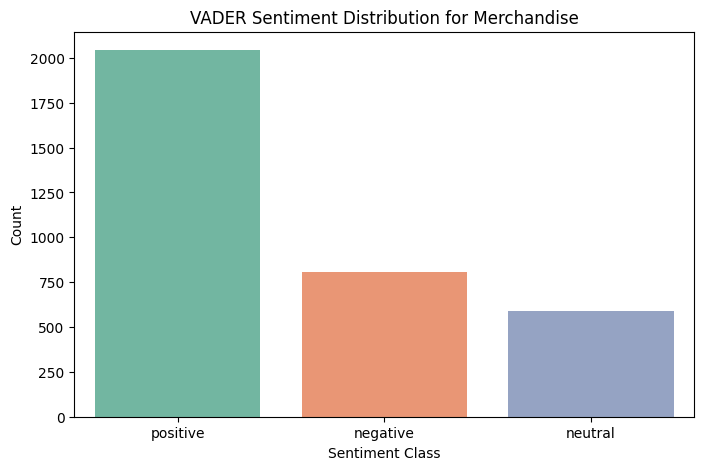

In [44]:
#Sentiment analysis on merch related posts
# Step 1: Apply VADER sentiment analysis
df_merch["vader_sentiment"] = df_merch["cleaned_text"].apply(analyze_sentiment_vader)
# Step 2: Classify sentiment
def classify_sentiment_vader(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"
df_merch["vader_sentiment_class"] = df_merch["vader_sentiment"].apply(classify_sentiment_vader)
# Step 3: Count sentiment classes
sentiment_counts_merch = df_merch["vader_sentiment_class"].value_counts()
print("VADER Sentiment Counts for Merchandise:")
print(sentiment_counts_merch)
# Step 4: Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="vader_sentiment_class", data=df_merch, palette="Set2")
plt.title("VADER Sentiment Distribution for Merchandise")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()


In [45]:
#Now I want to perform the LDA on the positive and negative sentiment posts related to merch
# Filter positive and negative sentiment posts
df_positive_merch = df_merch[df_merch["vader_sentiment_class"] == "positive"]
df_negative_merch = df_merch[df_merch["vader_sentiment_class"] == "negative"]
# Convert text using tfidf
vectorizer_pos_merch = TfidfVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm_positive_merch = vectorizer_pos_merch.fit_transform(df_positive_merch['cleaned_text'])
lda_positive_merch = LatentDirichletAllocation(n_components=5, random_state=42)
lda_positive_merch.fit(dtm_positive_merch)
# Display results
print("🛍️ Positive Sentiment Merchandise Topics:")
display_topics(lda_positive_merch, vectorizer_pos_merch.get_feature_names_out(), 5)
# Convert text using tfidf
vectorizer_neg_merch = TfidfVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm_negative_merch = vectorizer_neg_merch.fit_transform(df_negative_merch['cleaned_text'])
lda_negative_merch = LatentDirichletAllocation(n_components=5, random_state=42)
lda_negative_merch.fit(dtm_negative_merch)
# Display results
print("🛍️ Negative Sentiment Merchandise Topics:")
display_topics(lda_negative_merch, vectorizer_neg_merch.get_feature_names_out(), 5)

🛍️ Positive Sentiment Merchandise Topics:
Topic 0:
like design buy jacket good
Topic 1:
poster grand prix flair fanmade
Topic 2:
car design like style driver
Topic 3:
team driver year max quality
Topic 4:
hat merch shirt look livery
🛍️ Negative Sentiment Merchandise Topics:
Topic 0:
design limited track make look
Topic 1:
max hat style year lando
Topic 2:
car cap team cost driver
Topic 3:
quality buy shit red price
Topic 4:
merch f1 miami people thought


In [47]:
#I want to check the teams mentioned in the positive and negative sentiment posts related to merch
# Step 1: Extract teams mentioned in positive sentiment posts
def extract_teams_from_text(text, alias_lookup):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    mentioned_teams = set()
    for word in words:
        if word in alias_lookup:
            mentioned_teams.add(alias_lookup[word])
    return list(mentioned_teams)
# Step 2: Apply to positive sentiment posts
df_positive_merch["teams_mentioned"] = df_positive_merch["text"].apply(lambda x: extract_teams_from_text(x, alias_to_team))
# Step 3: Count mentions
positive_team_counts = defaultdict(int)
for teams in df_positive_merch["teams_mentioned"]:
    for team in teams:
        positive_team_counts[team] += 1
# Step 4: Convert to DataFrame
positive_team_df = pd.DataFrame(positive_team_counts.items(), columns=["team", "count"])
positive_team_df = positive_team_df.sort_values(by="count", ascending=False)
#Add a column for the realtive frquency
positive_team_df["relative_frequency"] = positive_team_df["count"] / len(df_positive_merch)

# Step 5: Display results
print("Positive Sentiment Team Mentions:")
print(positive_team_df)


# Step 1: Extract teams mentioned in negative sentiment posts
df_negative_merch["teams_mentioned"] = df_negative_merch["text"].apply(lambda x: extract_teams_from_text(x, alias_to_team))
# Step 2: Count mentions
negative_team_counts = defaultdict(int)
for teams in df_negative_merch["teams_mentioned"]:
    for team in teams:
        negative_team_counts[team] += 1
# Step 3: Convert to DataFrame
negative_team_df = pd.DataFrame(negative_team_counts.items(), columns=["team", "count"])
negative_team_df = negative_team_df.sort_values(by="count", ascending=False)
#Add a column for the relative frequency
negative_team_df["relative_frequency"] = negative_team_df["count"] / len(df_negative_merch)

# Step 4: Display results
print("Negative Sentiment Team Mentions:")
print(negative_team_df)

Positive Sentiment Team Mentions:
           team  count  relative_frequency
5      mercedes    316            0.154599
0      red bull    303            0.148239
7       ferrari    256            0.125245
1       mclaren    221            0.108121
3  aston martin    105            0.051370
6      williams     65            0.031800
8        alpine     62            0.030333
4    alphatauri     50            0.024462
2         stake     33            0.016145
9          haas     26            0.012720
Negative Sentiment Team Mentions:
           team  count  relative_frequency
2      red bull    104            0.128554
0      mercedes     98            0.121137
3       ferrari     85            0.105068
4       mclaren     83            0.102596
1  aston martin     26            0.032138
7        alpine     19            0.023486
5    alphatauri     16            0.019778
8      williams     11            0.013597
9          haas      6            0.007417
6         stake      4       